## Import Libraries

In [1]:
import sys
import os
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, validation_curve
from sklearn.pipeline import Pipeline
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score, mean_squared_error

warnings.filterwarnings('ignore')
%matplotlib inline

## Load Dataset

In [2]:
df = pd.read_csv('Dataset/final_merged_file.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71225 entries, 0 to 71224
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           71225 non-null  float64
 1   input_voltage  71225 non-null  float64
 2   el_power       71225 non-null  float64
dtypes: float64(3)
memory usage: 1.6 MB


## Split Features and Target for Training Data

In [3]:
X = df.drop(["el_power"], axis = 1)
y = df["el_power"]

## Split Training, Testing and Validation set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.80, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = 0.80, random_state = 42)

## Hyperparameter Tuning of ElasticNet Model with K-Fold Cross-Validation

In [5]:
folds = KFold(n_splits = 4, shuffle = True, random_state = 42)

hyper_param = {
    'elasticnet__alpha': np.logspace(-4, -3, 100),
    'elasticnet__l1_ratio': np.linspace(0, 1, 20)
}

pipeline = Pipeline([
    ('scaler', StandardScaler()),   # Step 1: Scale features
    ('elasticnet', ElasticNet())    # Step 2: Train ElasticNet regression model
])

clf = RandomizedSearchCV(pipeline,
                        param_distributions = hyper_param,
                        scoring = 'r2',
                        n_iter = 100,
                        cv = folds,
                        verbose = 1,
                        random_state = 42,
                        return_train_score = True
                            )

clf.fit(X_train, y_train)

Fitting 4 folds for each of 100 candidates, totalling 400 fits


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                             ('elasticnet', ElasticNet())]),
                   n_iter=100,
                   param_distributions={'elasticnet__alpha': array([0.0001    , 0.00010235, 0.00010476, 0.00010723, 0.00010975,
       0.00011233, 0.00011498, 0.00011768, 0.00012045, 0.00012328,
       0.00012619, 0.00012915, 0.00013219...
       0.00091116, 0.0009326 , 0.00095455, 0.00097701, 0.001     ]),
                                        'elasticnet__l1_ratio': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
                   random_state=42, return_train_score=True, scoring='r2',
                   verbose=1)

## Validation Curve for ElasticNet: Analyzing Alpha Parameter with RMSE

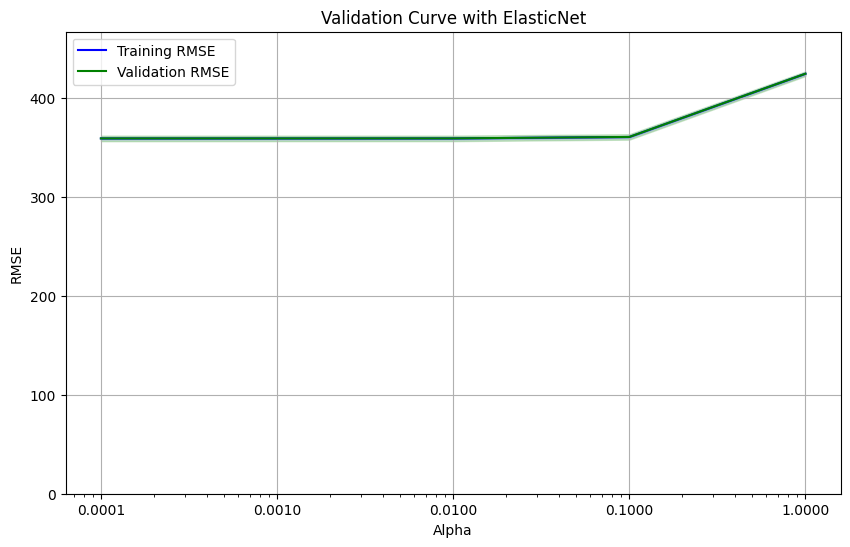

In [6]:
param_range = np.logspace(-4, 0, 5)

train_scores, valid_scores = validation_curve(
    pipeline, X_train, y_train, param_name = "elasticnet__alpha", param_range = np.logspace(-4, 0, 5),
    scoring = 'neg_mean_squared_error', n_jobs = -1, cv = folds
)

# Convert negative MSE to RMSE
train_rmse = np.sqrt(-train_scores)
valid_rmse = np.sqrt(-valid_scores)

# Calculate mean and standard deviation of scores for plotting
train_rmse_mean = np.mean(train_rmse, axis=1)
train_rmse_std = np.std(train_rmse, axis=1)
valid_rmse_mean = np.mean(valid_rmse, axis=1)
valid_rmse_std = np.std(valid_rmse, axis=1)

# Plotting the validation curve
plt.figure(figsize=(10, 6))
plt.title("Validation Curve with ElasticNet")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.ylim(0, max(train_rmse_mean.max(), valid_rmse_mean.max()) * 1.1)  # Adjust y-limits
plt.xscale("log")
plt.xticks(param_range, labels=[f'{p:.4f}' for p in param_range])  # Formatting ticks

# Plotting training RMSE
plt.plot(param_range, train_rmse_mean, label="Training RMSE", color="blue")
plt.fill_between(param_range, train_rmse_mean - train_rmse_std,
                 train_rmse_mean + train_rmse_std, color="blue", alpha=0.2)

# Plotting validation RMSE
plt.plot(param_range, valid_rmse_mean, label="Validation RMSE", color="green")
plt.fill_between(param_range, valid_rmse_mean - valid_rmse_std,
                 valid_rmse_mean + valid_rmse_std, color="green", alpha=0.2)

plt.legend(loc="best")
plt.grid()
plt.show()

## Evaluating Best ElasticNet Model

In [7]:
clf.best_params_

{'elasticnet__l1_ratio': 0.9473684210526315,
 'elasticnet__alpha': 0.0007924828983539178}

In [8]:
eNet_model = clf.best_estimator_

y_train_pred = eNet_model.predict(X_train)
y_val_pred = eNet_model.predict(X_val)

train_r2 = r2_score(y_train, y_train_pred)
val_r2 = r2_score(y_val, y_val_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))

print(f"Train R² Score: {train_r2:.4f}")
print(f"Validation R² Score: {val_r2:.4f}")
print(f"Train RMSE: {train_rmse}")
print(f"Validation RMSE: {val_rmse}")

Train R² Score: 0.7835
Validation R² Score: 0.7759
Train RMSE: 359.42586619746396
Validation RMSE: 365.8638449392197


## Predicted vs Actual Values (Train Set)

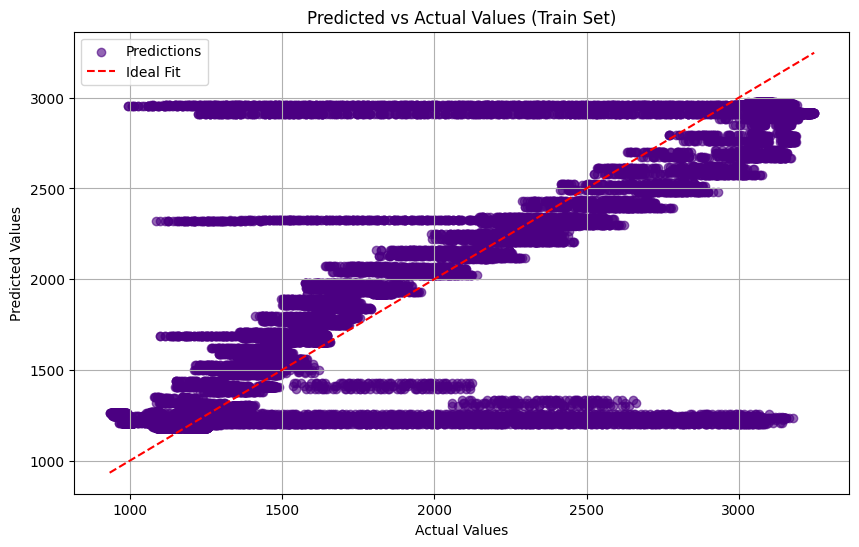

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_train_pred, color='indigo', label='Predictions', alpha=0.6)
min_val = min(y_train.min(), y_train_pred.min())
max_val = max(y_train.max(), y_train_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Train Set)')
plt.legend()
plt.grid(True)
plt.show()

## Model Evaluation on Test Data

In [10]:
y_test_pred = eNet_model.predict(X_test)

test_r2 = r2_score(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

print(f"Test R² Score: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse}")

Test R² Score: 0.7930
Test RMSE: 353.8616154599869


## Predicted vs Actual Values (Test Set)

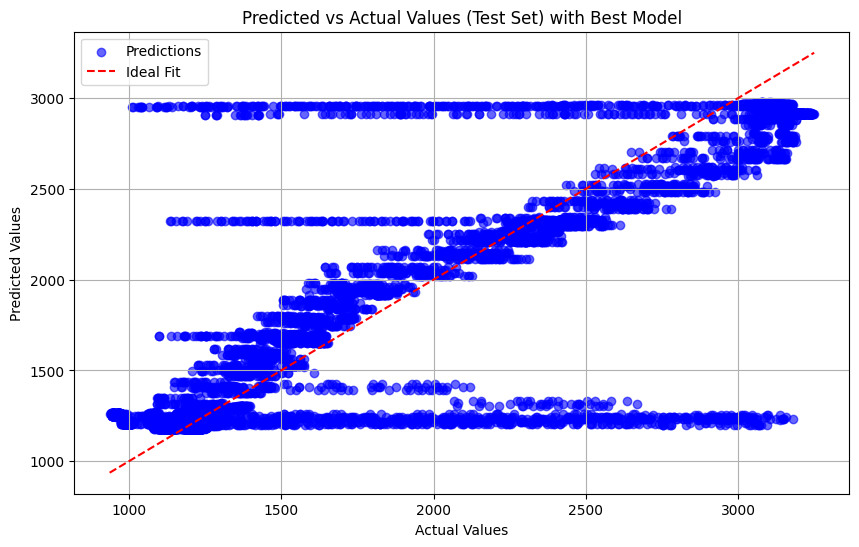

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, color='blue', label='Predictions', alpha=0.6)
min_val = min(y_test.min(), y_test_pred.min())
max_val = max(y_test.max(), y_test_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values (Test Set) with Best Model')
plt.legend()
plt.grid(True)
plt.show()